# HON Overlaid InfoMap Communities
Plotting HON communities found by InfoMap, overlaid in color.

In [1]:
import matplotlib
#matplotlib.use('Agg')
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import signac
from util import fetch_geodata
from tqdm import tqdm

project = signac.get_project()
job = project.find_jobs({"year": 2011, "quarter": 1}).next()

In [2]:
communities = pd.read_csv(job.fn('hon_communities.csv'), usecols=['path', 'flow', 'ID', 'IATA', 'lon', 'lat'])
communities.path = communities.path.apply(lambda x: tuple(map(int, x[1:-1].split(', '))))

In [3]:
def get_community(paths, community_path):
    if len(community_path) == 3:
        left = tuple([*community_path[:-1], community_path[-1]-1])
        right = tuple([*community_path[:-1], community_path[-1]+1])
    else:
        left = tuple([*community_path, *(-1,)*(3-len(community_path))])
        right = tuple([*community_path[:-1], community_path[-1]+1, *(0,)*(3-len(community_path))])
    return paths[paths.path.between(left, right)]

In [4]:
all_communities = [get_community(communities, community) for community in tqdm(communities.path.apply(lambda x: x[:2]).unique())]

100%|██████████| 7622/7622 [00:58<00:00, 130.45it/s]


In [7]:
def plot_communities(all_communities, top_count=5):
    print('Generating plot...')
    fig = plt.figure(figsize=(6, 4), dpi=400)
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
    ax.set_extent([-128, -64, 22, 49], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)

    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    plt.title('Top {} Communities from Higher-Order Network ({}Q{})'.format(
        top_count, job.sp.year, job.sp.quarter))

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.8594)
        return {'facecolor': facecolor, 'edgecolor': 'black'}

    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        styler=colorize_state)

    cmap = matplotlib.cm.get_cmap('tab10')
    marked_iatas = set()
    for i, paths in enumerate(
            sorted(all_communities, key=lambda x: -sum(x.flow))[:top_count]):
        xs = paths.lon.values
        ys = paths.lat.values
        colors = (cmap(i),) * len(xs)
        sizes = 10000*paths.flow.values
        dots = ax.scatter(xs, ys, transform=ccrs.PlateCarree(), c=colors, s=sizes, alpha=0.8, zorder=10)

        top_n = paths.sort_values('flow', ascending=False).head(10).index
        for row in paths.loc[top_n].itertuples():
            if row.IATA not in marked_iatas:
                ax.annotate(row.IATA, (row.lon, row.lat), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                            fontsize=10, #40*row.flow**0.2,
                            zorder=11, ha='center', va='center')
                marked_iatas.add(row.IATA)
    #plt.savefig(job.fn('hon_communities.png'))
    plt.show()
    plt.close()

Generating plot...


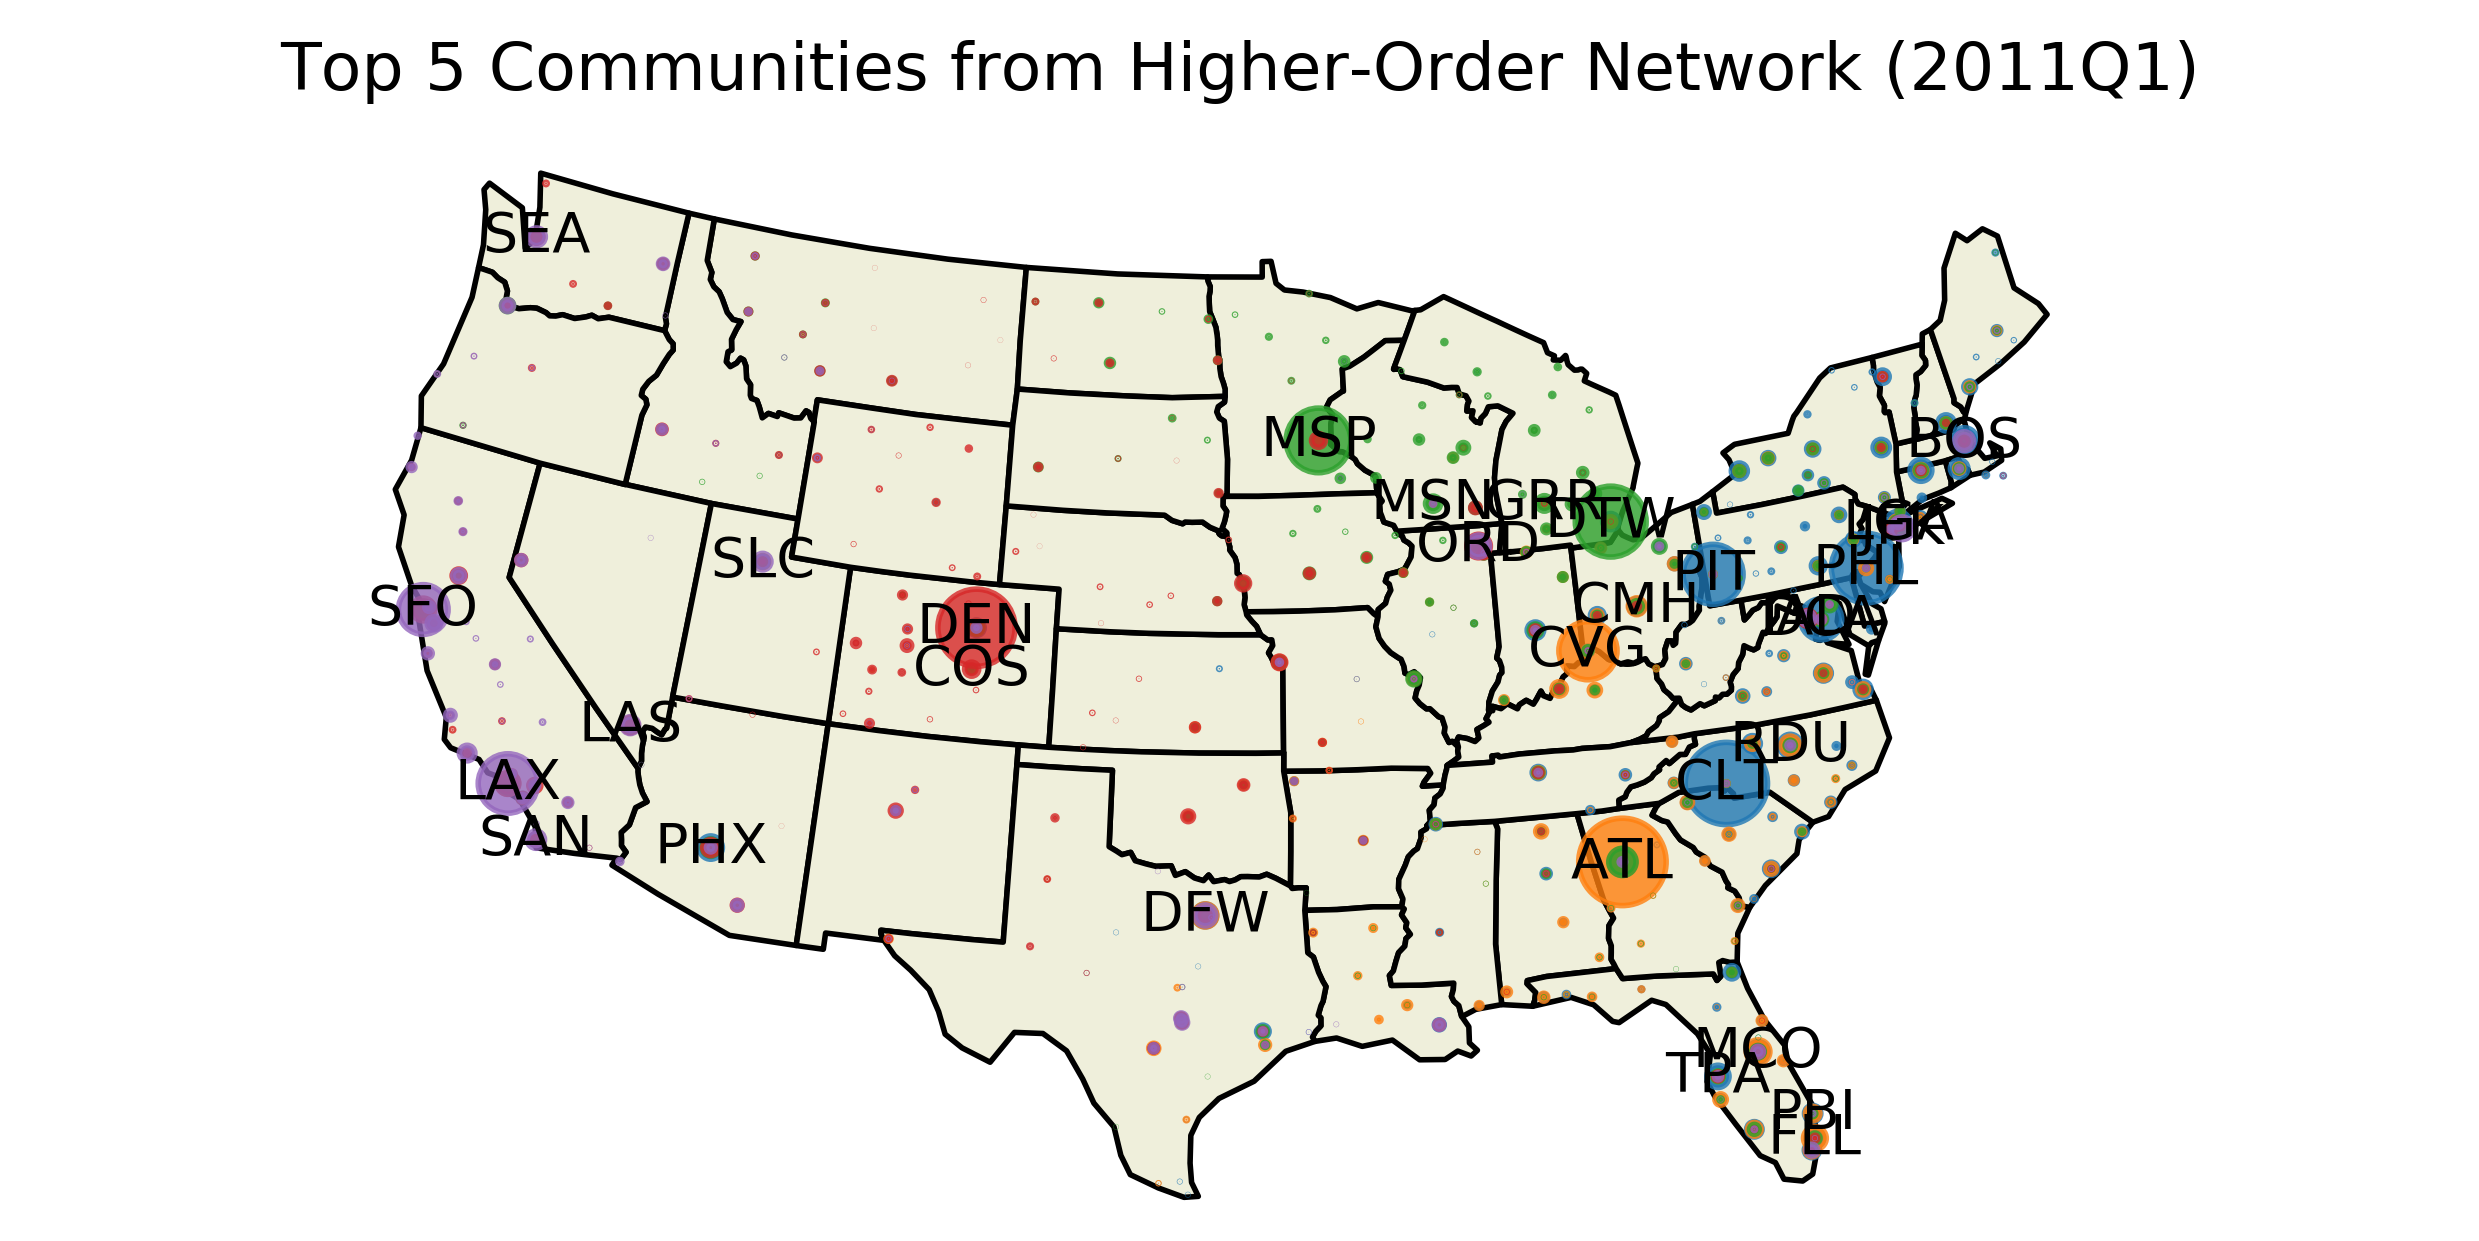

In [8]:
plot_communities(all_communities, 5)